S(t) = α y(t)/I(t-L)   +   (1-α)(S(t-1) + b(t-1))   Smoothing Formula

b(t) = γ(S(t) - S(t-1)) + (1-γ)(b(t-1))             Trend Smoothing

I(t) = β y(t)/S(t) + (1-β)I(t-L)                    Seasonal Smoothing

F(t+m) = (S(t)+mb(t))I(t-L+m)                       Forecast


α  Smoothing Constant

β  Seasonal Constant

γ  Trend Constant

L  Period

Period is the number of periods in a year. In this input its 12.


Initial Values for S, b and I are calculated as follows:

b = 1/L ((y(L+1) - y(1)/L) + (y(L+2) - y(2)/L) . . . (y(L+L) - y(L)/L))


Average of number of cycle ( number of years in the input data )

A(p) = ∑yi/4  where i is 1 to 4, p = 1,2,3.... upto number of cycle.


I(1) = (y1/A1 + y5/A2 + y9/A3 + y13/A4 + y17/A5 + y21/A6...)/<number of cycle>

I(2) = (y2/A1 + y6/A2 + y10/A3 + y14/A4 + y18/A5 + y22/A6...)/<number of cycle>

I(3) = (y3/A1 + y7/A2 + y11/A3 + y15/A4 + y19/A5 + y23/A6...)/<number of cycle>

I(4) = (y4/A1 + y8/A2 + y12/A3 + y16/A4 + y20/A5 + y24/A6...)/<number of cycle>


Initial value of S = first observation of y

S and b are scalar values whereas I is a vector of m period which will be accessed by MOD to get the position of the cycle. 



This Holt Winters code is very sinmple and straightforward coding. I didn't use any class object in this code as my
objective is mainly on the understanding of the Exponential Smoothing techniques.  There are packages ready available 
to use to get the forecasting model and report. Purpose of my work is help someone to understand how the smoothing is 
done step by step. This code also doesn't have optimized alpha, beta and gamma constant values. 

This is my reference to concept: https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm

As I am done with Holt Winters, next will be ARIMA model step by step coding. See you soon!!


Note: I will keep updating this repository with new and changed code for better optimization. 

I have come across this Nasdaq historical data and thought will apply Holt Winters formula to check how the forecasting will be
on this data. 
I also tried to split train and test data and validated test data with the forecasting based on train data using Holt Winter as well as my own formula.  
This will have two parts one with full data and another with train and test split. Again I tried the data using Holt Winter package as well as my formula.  

              nasdaq
date                
1971-02-01    693.37
1971-03-01    723.25
1971-04-01    764.54
1971-05-01    733.29
1971-06-01    724.85
...              ...
2021-04-01  14269.86
2021-05-01  13941.22
2021-06-01  14576.47
2021-07-01  14672.68
2021-08-01  14541.79

[607 rows x 1 columns]


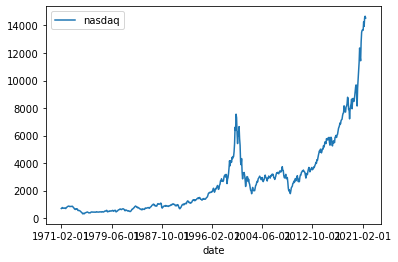

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from matplotlib import pyplot as plt
from sklearn import model_selection as skl
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

#path = 'monthly-car-sales.csv'
path = 'nasdaq_historical_data.csv'
df = pd.read_csv(path, header=0)


df.index = df['date']
df.drop(['Unnamed: 2', 'date'],axis =1 , inplace=True)


print(df)

df.plot()
plt.show()

In [135]:
df_new = df.copy()

print(df_new)
L = 12

b = 0

df_new['S'] = 0

df_new['b'] = 0


df_new['predict'] = 0.00

df_forecast = []
       
S_initial = 0

b_initial = 0

#Get the initial smoothing value

S_initial = df_new['nasdaq'][0]

#Get the initial trend value

for i in range(L):
    b += (df_new['nasdaq'][L+i] - df_new['nasdaq'][i])/L
    
b_initial = b/L


              nasdaq
date                
1971-02-01    693.37
1971-03-01    723.25
1971-04-01    764.54
1971-05-01    733.29
1971-06-01    724.85
...              ...
2021-04-01  14269.86
2021-05-01  13941.22
2021-06-01  14576.47
2021-07-01  14672.68
2021-08-01  14541.79

[607 rows x 1 columns]


In [136]:
#Find the number of cycle in the input
num_cyc = 0
length = len(df_new)

start_year = df_new.index[0][:4]
end_year = df_new.index[len(df_new)-1][:4]

start_year = int(start_year)
end_year = int(end_year)

num_cyc = end_year - start_year
print(num_cyc)

num_cyc += 1

Ap = []

#Get the initial value for I

#First compute the average for each cycle(year)

for i in range(1,num_cyc+1):
    if i == 1:
        #Ap.extend((df_new.iloc[i-1:i+11,1:2].sum()/12).astype(int))
        Ap.extend((df_new.iloc[i-1:i+11,0:1].sum()/12).astype(int))
        x = i+11
    else:
        Ap.append((df_new.iloc[x:x+12,0:1].sum()/12).astype(int))
        x = x+12
        
        

        
       
    


50


In [137]:

#Compute intial Seaonal Index

I = []
x = 0
for i in range(L):
    seasonal = 0
    x = 0
    for j in range(num_cyc):        
        if j == 0:
            seasonal+= ((df_new['nasdaq'][i])/Ap[j])
        else:
            x = x+12
            seasonal+= df_new['nasdaq'][x]/Ap[j]
        
    I.extend(seasonal/num_cyc)

    
print(I)

[0.9962889455978283, 0.9970937290496708, 0.9982058277352988, 0.9973641449083218, 0.9971368232104119, 0.996633160206749, 0.9971527141821852, 0.9972626042920752, 0.9965089951561135, 0.9963059139236203, 0.9980294110147645, 0.9988789046583758]


In [138]:
#To find the forecasting

def holt_winters_forecast(df_new,L,I,forecast_value):
    
    a=0.1
    g=0.2
    b=0.3
    y = 0.0
    m = 0
    
    for i in range(len(df_new)+ forecast_value):
 
        
        if i >= len(df_new):
                                
            m += 1
            
           #forecast formula F(t+m) = (S(t)+b(t))*I(t-L+m)
        
            df_forecast.append((df_new['S'][len(df_new)-1] + (m*df_new['b'][len(df_new)-1])) * (I[i%L]))
            
        elif i == 0:
            
            df_new['S'][i] = (a*(df_new['nasdaq'][i]/I[i])) + ((1-a)*(S_initial + b_initial))

            df_new['b'][i] = g*(df_new['S'][i] - S_initial) + (1-g) * ( b_initial)
               
            I[i] = b*(df_new['nasdaq'][i]/df_new['S'][i]) + (1-b)*I[i]
            
            df_new['predict'][i] = (df_new['S'][i] + df_new['b'][i]) * (I[i%L])
            
        else:
            
            df_new['S'][i] = (a*(df_new['nasdaq'][i]/I[i%L])) + ((1-a)*(df_new['S'][i-1] + df_new['b'][i-1]))

            df_new['b'][i] = g*(df_new['S'][i] - df_new['S'][i-1]) + (1-g) * (df_new['b'][i-1])

            I[i%L] = b*(df_new['nasdaq'][i]/df_new['S'][i]) + (1-b)*I[i%L]
            

            df_new['predict'][i] = (df_new['S'][i] + df_new['b'][i]) * (I[i%L])
    
    
    return df_new,df_forecast
    
holt_winters_forecast(df_new,L,I,forecast_value= 24)



(              nasdaq     S    b       predict
 date                                         
 1971-02-01    693.37   702    9    706.530816
 1971-03-01    723.25   712    9    722.950867
 1971-04-01    764.54   725    9    745.087407
 1971-05-01    733.29   734    9    741.413480
 1971-06-01    724.85   741    8    742.601529
 ...              ...   ...  ...           ...
 2021-04-01  14269.86  8894  263  14217.337281
 2021-05-01  13941.22  9146  260  14438.621002
 2021-06-01  14576.47  9397  258  15063.940001
 2021-07-01  14672.68  9605  248  15561.551717
 2021-08-01  14541.79  9764  230  15815.082589
 
 [607 rows x 4 columns],
 [15670.545694865432,
  15713.262680259731,
  16646.677716797883,
  16937.56865478376,
  17351.90932972216,
  17291.375130055854,
  17070.43068103464,
  18016.597336711955,
  18165.7070946837,
  18822.51394889165,
  19416.798620588306,
  19818.70065516632,
  19998.212906975557,
  19955.105892066935,
  21041.629935887435,
  21313.054379905738,
  21739.967763846

In [139]:
def forecast_time(df_forecast,df_new):

    df_new_forecast = df_forecast.copy()

    df_new_forecast = pd.DataFrame(df_new_forecast,columns = ['forecast'])

    df_new_forecast['Month'] = [0]*len(df_new_forecast['forecast'])

    df_new_forecast['Month'] = pd.to_datetime(df_new_forecast['Month'])
    
    df_new['Month'] = df_new.index
    
    df_new['Month'] = pd.to_datetime(df_new['Month'])


    temp_value = df_new['Month'][-1]

    temp_value = pd.to_datetime(temp_value)

    for i in range(len(df_forecast)):
        
        if i == 0:
            df_new_forecast['Month'][i] = temp_value + pd.DateOffset(months=1)
        else:
            df_new_forecast['Month'][i] = df_new_forecast['Month'][i-1]+pd.DateOffset(months=1)
            

    df_new_forecast = df_new_forecast.set_index('Month')
    
    df_new.reset_index(drop=True, inplace=True)
    
    df_new = df_new.set_index('Month')
    
            
    return df_new_forecast,df_new


df_new_forecast,df_new = forecast_time(df_forecast,df_new)
print(df_new_forecast)
print(df_new)

                forecast
Month                   
2021-09-01  15670.545695
2021-10-01  15713.262680
2021-11-01  16646.677717
2021-12-01  16937.568655
2022-01-01  17351.909330
2022-02-01  17291.375130
2022-03-01  17070.430681
2022-04-01  18016.597337
2022-05-01  18165.707095
2022-06-01  18822.513949
2022-07-01  19416.798621
2022-08-01  19818.700655
2022-09-01  19998.212907
2022-10-01  19955.105892
2022-11-01  21041.629936
2022-12-01  21313.054380
2023-01-01  21739.967764
2023-02-01  21573.876508
2023-03-01  21212.719118
2023-04-01  22301.827313
2023-05-01  22402.427695
2023-06-01  23128.725694
2023-07-01  23775.865173
2023-08-01  24186.284000
              nasdaq     S    b       predict
Month                                        
1971-02-01    693.37   702    9    706.530816
1971-03-01    723.25   712    9    722.950867
1971-04-01    764.54   725    9    745.087407
1971-05-01    733.29   734    9    741.413480
1971-06-01    724.85   741    8    742.601529
...              ...   ...  

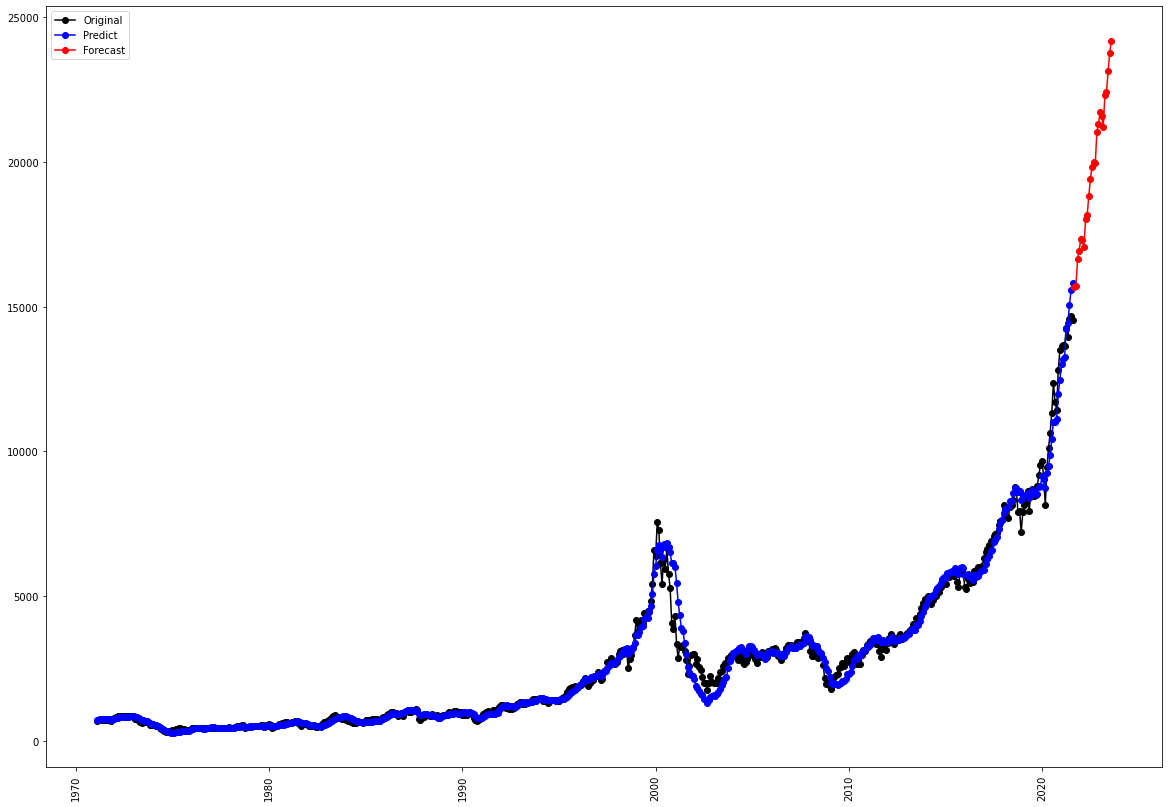

In [140]:
plt.figure(figsize=(20, 14))

x, = plt.plot(df_new['nasdaq'], marker='o', color='black')

y, = plt.plot(df_new['predict'], marker='o', color='blue')

z, = plt.plot(df_new_forecast['forecast'],marker='o',color='red')

plt.xticks(rotation = 'vertical')

plt.legend([x,y,z],['Original','Predict','Forecast'])

plt.show()

In [141]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as holt


sales_holt = holt(df_new['nasdaq'],trend = 'add', seasonal='add', seasonal_periods=12)

sales_fit = sales_holt.fit()

prediction = sales_fit.predict()

forecast = sales_fit.forecast(24)



In [142]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as holt

df_holt = df_new.copy()

df_holt.index = pd.to_datetime(df_holt.index)

#df_holt.index = df_holt.index + '-01'

#df_holt.index = df_holt.astype(datetime)

sales_holt = holt(df_holt['nasdaq'],trend = 'add', seasonal='add', seasonal_periods=12)

sales_fit = sales_holt.fit()

prediction = sales_fit.predict()

forecast = sales_fit.forecast(24)

Month
1971-02-01      693.37
1971-03-01      723.25
1971-04-01      764.54
1971-05-01      733.29
1971-06-01      724.85
                ...   
2021-04-01    14269.86
2021-05-01    13941.22
2021-06-01    14576.47
2021-07-01    14672.68
2021-08-01    14541.79
Name: nasdaq, Length: 607, dtype: float64
2021-09-01    14669.788320
2021-10-01    14864.867669
2021-11-01    15104.540057
2021-12-01    15285.061360
2022-01-01    15485.565652
2022-02-01    15625.507916
2022-03-01    15773.203979
2022-04-01    16003.995068
2022-05-01    16139.949721
2022-06-01    16358.875531
2022-07-01    16539.750635
2022-08-01    16704.204260
2022-09-01    16817.132997
2022-10-01    17012.212346
2022-11-01    17251.884734
2022-12-01    17432.406037
2023-01-01    17632.910329
2023-02-01    17772.852593
2023-03-01    17920.548656
2023-04-01    18151.339745
2023-05-01    18287.294398
2023-06-01    18506.220208
2023-07-01    18687.095312
2023-08-01    18851.548937
Freq: MS, dtype: float64


<AxesSubplot:xlabel='Month'>

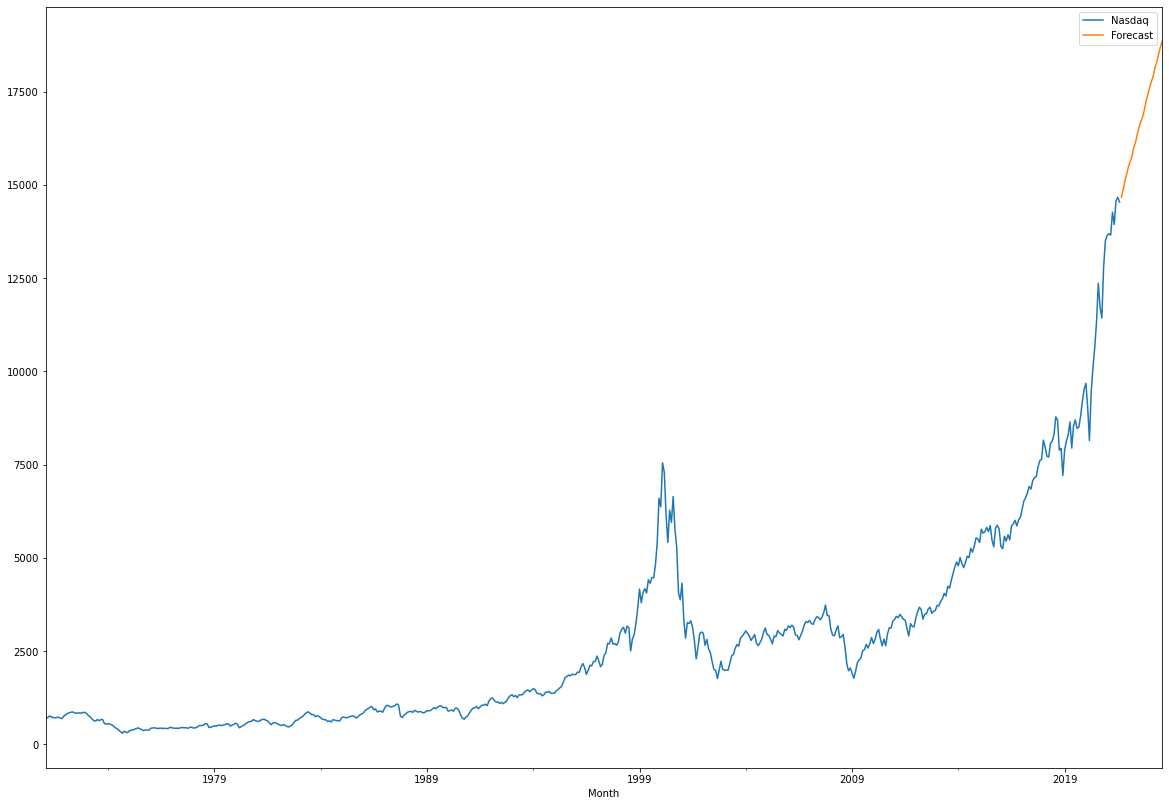

In [143]:
print(df_holt['nasdaq'])

print(forecast)

plt.figure(figsize=(20, 14))

df_holt['nasdaq'].plot(legend=True,label = 'Nasdaq')

forecast.plot(legend=True,label = 'Forecast')

Splitting the train and test data and code will use this data from here. I tried to keep 12 months period for each year while split the data.  That way train will have full cycle data. 

In [349]:
train_data_size = round(len(df['nasdaq'])*.77)
print(len(df)-train_data_size)
train_data = df.iloc[:train_data_size]
test_data = df.iloc[train_data_size:]

df_test = test_data.copy()

df_test['Month'] =  pd.to_datetime(df_test.index)

df_test = df_test.set_index('Month')

print((train_data))
print((test_data))

140
             nasdaq
date               
1971-02-01   693.37
1971-03-01   723.25
1971-04-01   764.54
1971-05-01   733.29
1971-06-01   724.85
...             ...
2009-08-01  2541.46
2009-09-01  2682.74
2009-10-01  2582.97
2009-11-01  2706.49
2009-12-01  2868.21

[467 rows x 1 columns]
              nasdaq
date                
2010-01-01   2705.66
2010-02-01   2820.21
2010-03-01   3007.04
2010-04-01   3081.41
2010-05-01   2823.56
...              ...
2021-04-01  14269.86
2021-05-01  13941.22
2021-06-01  14576.47
2021-07-01  14672.68
2021-08-01  14541.79

[140 rows x 1 columns]


In [350]:
df_new = []

df_new = train_data.copy()

print(df_new)

L = 12

b = 0

df_new['S'] = 0

df_new['b'] = 0


df_new['predict'] = 0.00

df_forecast = []
       
S_initial = 0

b_initial = 0

#Get the initial smoothing value

S_initial = df_new['nasdaq'][0]

#Get the initial trend value

for i in range(L):
    b += (df_new['nasdaq'][L+i] - df_new['nasdaq'][i])/L
    
b_initial = b/L


             nasdaq
date               
1971-02-01   693.37
1971-03-01   723.25
1971-04-01   764.54
1971-05-01   733.29
1971-06-01   724.85
...             ...
2009-08-01  2541.46
2009-09-01  2682.74
2009-10-01  2582.97
2009-11-01  2706.49
2009-12-01  2868.21

[467 rows x 1 columns]


In [351]:
#Find the number of cycle in the input
num_cyc = 0
length = len(df_new)

start_year = df_new.index[0][:4]
end_year = df_new.index[len(df_new)-1][:4]

start_year = int(start_year)
end_year = int(end_year)

num_cyc = end_year - start_year

num_cyc += 1

Ap = []

#Get the initial value for I

#First compute the average for each cycle(year)

for i in range(1,num_cyc+1):
    if i == 1:
        #Ap.extend((df_new.iloc[i-1:i+11,1:2].sum()/12).astype(int))
        Ap.extend((df_new.iloc[i-1:i+11,0:1].sum()/12).astype(int))
        x = i+11
    else:
        Ap.append((df_new.iloc[x:x+12,0:1].sum()/12).astype(int))
        x = x+12
        
        
print(Ap)

        
       
    


[728, nasdaq    846
dtype: int32, nasdaq    644
dtype: int32, nasdaq    402
dtype: int32, nasdaq    401
dtype: int32, nasdaq    436
dtype: int32, nasdaq    443
dtype: int32, nasdaq    493
dtype: int32, nasdaq    524
dtype: int32, nasdaq    567
dtype: int32, nasdaq    605
dtype: int32, nasdaq    551
dtype: int32, nasdaq    786
dtype: int32, nasdaq    649
dtype: int32, nasdaq    753
dtype: int32, nasdaq    930
dtype: int32, nasdaq    949
dtype: int32, nasdaq    876
dtype: int32, nasdaq    967
dtype: int32, nasdaq    840
dtype: int32, nasdaq    1037
dtype: int32, nasdaq    1183
dtype: int32, nasdaq    1374
dtype: int32, nasdaq    1377
dtype: int32, nasdaq    1715
dtype: int32, nasdaq    2090
dtype: int32, nasdaq    2530
dtype: int32, nasdaq    3154
dtype: int32, nasdaq    4748
dtype: int32, nasdaq    5718
dtype: int32, nasdaq    2980
dtype: int32, nasdaq    2225
dtype: int32, nasdaq    2549
dtype: int32, nasdaq    2873
dtype: int32, nasdaq    2954
dtype: int32, nasdaq    3099
dtype: int32

In [352]:

#Compute intial Seaonal Index

I = []
x = 0
for i in range(L):
    seasonal = 0
    x = 0
    for j in range(num_cyc):        
        if j == 0:
            seasonal+= ((df_new['nasdaq'][i])/Ap[j])
        else:
            x = x+12
            seasonal+= df_new['nasdaq'][x]/Ap[j]
        
    I.extend(seasonal/num_cyc)

    


In [353]:
#To find the forecasting

def holt_winters_forecast(df_new,L,I,forecast_value):
    
    a=0.1
    g=0.2
    b=0.3
    y = 0.0
    m = 0
    
    for i in range(len(df_new)+ forecast_value):
 
        
        if i >= len(df_new):
                                
            m += 1
            
           #forecast formula F(t+m) = (S(t)+b(t))*I(t-L+m)
        
            df_forecast.append((df_new['S'][len(df_new)-1] + (m*df_new['b'][len(df_new)-1])) * (I[i%L]))
            
        elif i == 0:
            
            df_new['S'][i] = (a*(df_new['nasdaq'][i]/I[i])) + ((1-a)*(S_initial + b_initial))

            df_new['b'][i] = g*(df_new['S'][i] - S_initial) + (1-g) * ( b_initial)
               
            I[i] = b*(df_new['nasdaq'][i]/df_new['S'][i]) + (1-b)*I[i]
            
            df_new['predict'][i] = (df_new['S'][i] + df_new['b'][i]) * (I[i%L])
            
        else:
            
            df_new['S'][i] = (a*(df_new['nasdaq'][i]/I[i%L])) + ((1-a)*(df_new['S'][i-1] + df_new['b'][i-1]))

            df_new['b'][i] = g*(df_new['S'][i] - df_new['S'][i-1]) + (1-g) * (df_new['b'][i-1])

            I[i%L] = b*(df_new['nasdaq'][i]/df_new['S'][i]) + (1-b)*I[i%L]
            

            df_new['predict'][i] = (df_new['S'][i] + df_new['b'][i]) * (I[i%L])
    
    
    return df_new,df_forecast
    
holt_winters_forecast(df_new,L,I,forecast_value= 140)



(             nasdaq     S   b      predict
 date                                      
 1971-02-01   693.37   702   9   706.170482
 1971-03-01   723.25   712   9   722.710442
 1971-04-01   764.54   725   9   745.018461
 1971-05-01   733.29   734   9   741.208994
 1971-06-01   724.85   741   8   742.358719
 ...             ...   ...  ..          ...
 2009-08-01  2541.46  1352 -45  2009.445956
 2009-09-01  2682.74  1374 -31  2056.481047
 2009-10-01  2582.97  1401 -19  2059.504181
 2009-11-01  2706.49  1447  -6  2148.913080
 2009-12-01  2868.21  1508   7  2300.436456
 
 [467 rows x 4 columns],
 [2011.6201023664557,
  1973.739851988143,
  2063.9028633052394,
  2195.2021020766474,
  2279.143981683207,
  2289.131884975938,
  2359.648957664985,
  2404.570371144527,
  2405.6081341011336,
  2351.5901579679853,
  2363.655261228881,
  2417.3563291132455,
  2123.1554743788533,
  2082.671617800892,
  2177.289286142153,
  2315.252217033964,
  2403.219221126752,
  2413.188064548828,
  2486.951791604

In [354]:
def forecast_time(df_forecast,df_new):

    df_new_forecast = df_forecast.copy()

    df_new_forecast = pd.DataFrame(df_new_forecast,columns = ['forecast'])

    df_new_forecast['Month'] = [0]*len(df_new_forecast['forecast'])

    df_new_forecast['Month'] = pd.to_datetime(df_new_forecast['Month'])
    
    df_new['Month'] = df_new.index
    
    df_new['Month'] = pd.to_datetime(df_new['Month'])


    temp_value = df_new['Month'][-1]

    temp_value = pd.to_datetime(temp_value)

    for i in range(len(df_forecast)):
        
        if i == 0:
            df_new_forecast['Month'][i] = temp_value + pd.DateOffset(months=1)
        else:
            df_new_forecast['Month'][i] = df_new_forecast['Month'][i-1]+pd.DateOffset(months=1)
            

    df_new_forecast = df_new_forecast.set_index('Month')
    
    df_new.reset_index(drop=True, inplace=True)
    
    df_new = df_new.set_index('Month')
    
            
    return df_new_forecast,df_new


df_new_forecast,df_new = forecast_time(df_forecast,df_new)
print(df_new_forecast)
print(test_data)
print(df_new)


               forecast
Month                  
2010-01-01  2011.620102
2010-02-01  1973.739852
2010-03-01  2063.902863
2010-04-01  2195.202102
2010-05-01  2279.143982
...                 ...
2021-04-01  3515.753367
2021-05-01  3643.971616
2021-06-01  3653.749860
2021-07-01  3759.980131
2021-08-01  3825.173327

[140 rows x 1 columns]
              nasdaq
date                
2010-01-01   2705.66
2010-02-01   2820.21
2010-03-01   3007.04
2010-04-01   3081.41
2010-05-01   2823.56
...              ...
2021-04-01  14269.86
2021-05-01  13941.22
2021-06-01  14576.47
2021-07-01  14672.68
2021-08-01  14541.79

[140 rows x 1 columns]
             nasdaq     S   b      predict
Month                                     
1971-02-01   693.37   702   9   706.170482
1971-03-01   723.25   712   9   722.710442
1971-04-01   764.54   725   9   745.018461
1971-05-01   733.29   734   9   741.208994
1971-06-01   724.85   741   8   742.358719
...             ...   ...  ..          ...
2009-08-01  2541.46  13

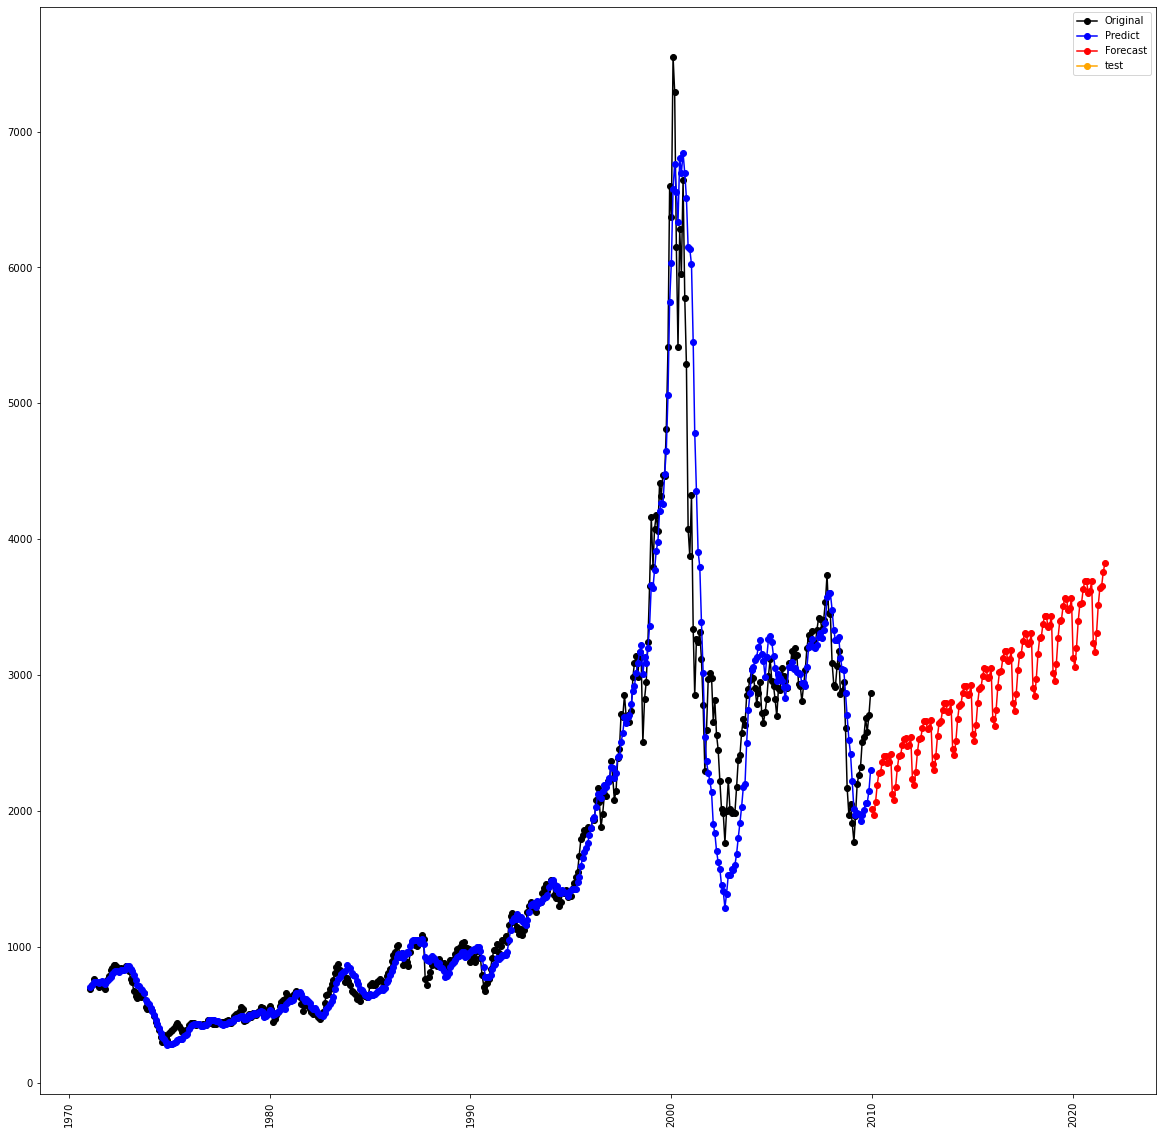

In [355]:
plt.figure(figsize=(20, 20))

x, = plt.plot(df_new['nasdaq'], marker='o', color='black')

y, = plt.plot(df_new['predict'], marker='o', color='blue')

z, = plt.plot(df_new_forecast['forecast'],marker='o',color='red')

#a, = plt.plot(test_data, marker='o', color='orange')

plt.xticks(rotation = 'vertical')

plt.legend([x,y,z,a],['Original','Predict','Forecast','test'])

plt.show()

In [356]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as holt


sales_holt = holt(train_data['nasdaq'],trend = 'add', seasonal='add', seasonal_periods=12)

sales_fit = sales_holt.fit()

prediction = sales_fit.predict()

forecast = sales_fit.forecast(140)



In [357]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as holt

df_holt = train_data.copy()



df_holt.index = pd.to_datetime(df_holt.index)

#df_holt.index = df_holt.index + '-01'

#df_holt.index = df_holt.astype(datetime)

sales_holt = holt(df_holt['nasdaq'],trend = 'add', seasonal='add', seasonal_periods=12)

sales_fit = sales_holt.fit()

prediction = sales_fit.predict()

forecast = sales_fit.forecast(140)

date
1971-02-01     693.37
1971-03-01     723.25
1971-04-01     764.54
1971-05-01     733.29
1971-06-01     724.85
               ...   
2009-08-01    2541.46
2009-09-01    2682.74
2009-10-01    2582.97
2009-11-01    2706.49
2009-12-01    2868.21
Name: nasdaq, Length: 467, dtype: float64
2010-01-01    2884.175819
2010-02-01    2863.313740
2010-03-01    2860.037273
2010-04-01    2859.801256
2010-05-01    2860.303352
                 ...     
2021-04-01    3362.499375
2021-05-01    3363.001471
2021-06-01    3385.759519
2021-07-01    3367.529119
2021-08-01    3378.127310
Freq: MS, Length: 140, dtype: float64


<AxesSubplot:xlabel='date'>

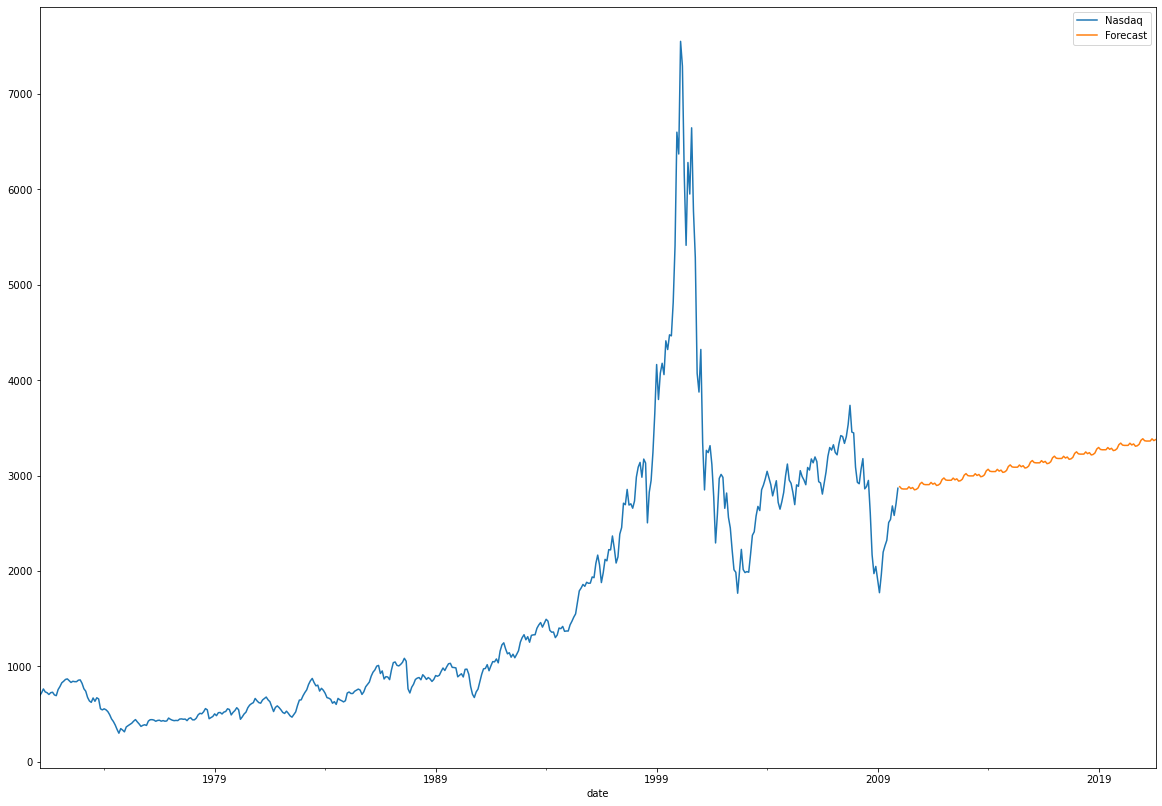

In [358]:
print(df_holt['nasdaq'])

print(forecast)

plt.figure(figsize=(20, 14))

df_holt['nasdaq'].plot(legend=True,label = 'Nasdaq')

forecast.plot(legend=True,label = 'Forecast')

In [359]:
print(forecast)


2010-01-01    2884.175819
2010-02-01    2863.313740
2010-03-01    2860.037273
2010-04-01    2859.801256
2010-05-01    2860.303352
                 ...     
2021-04-01    3362.499375
2021-05-01    3363.001471
2021-06-01    3385.759519
2021-07-01    3367.529119
2021-08-01    3378.127310
Freq: MS, Length: 140, dtype: float64


In [360]:
print(df_new_forecast)

               forecast
Month                  
2010-01-01  2011.620102
2010-02-01  1973.739852
2010-03-01  2063.902863
2010-04-01  2195.202102
2010-05-01  2279.143982
...                 ...
2021-04-01  3515.753367
2021-05-01  3643.971616
2021-06-01  3653.749860
2021-07-01  3759.980131
2021-08-01  3825.173327

[140 rows x 1 columns]


In [361]:
print(df_test)

              nasdaq
Month               
2010-01-01   2705.66
2010-02-01   2820.21
2010-03-01   3007.04
2010-04-01   3081.41
2010-05-01   2823.56
...              ...
2021-04-01  14269.86
2021-05-01  13941.22
2021-06-01  14576.47
2021-07-01  14672.68
2021-08-01  14541.79

[140 rows x 1 columns]


Now we have test data as forecasted data using Holt Winter formula. I want to compare test data with the forecast data from two models. 

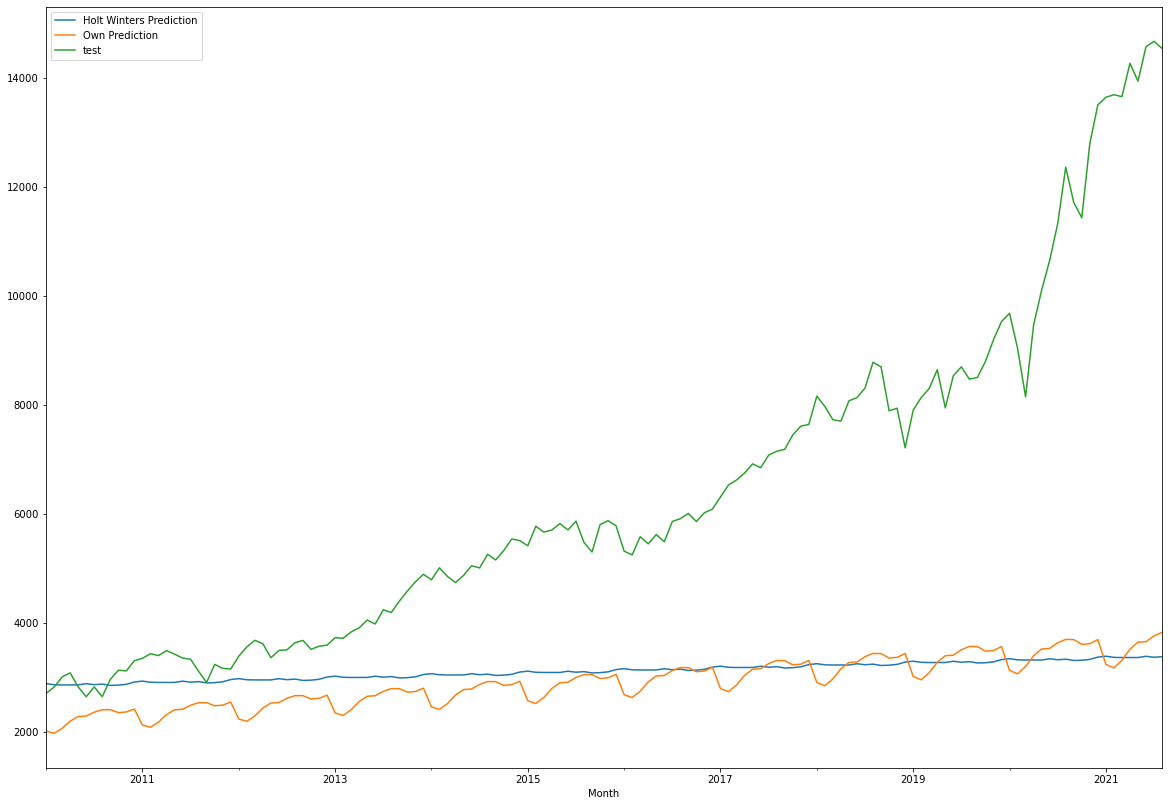

In [362]:
plt.figure(figsize=(20, 14))


forecast.plot(legend=True,label = 'Holt Winters Prediction')

df_new_forecast['forecast'].plot(legend=True, label='Own Prediction')

df_test['nasdaq'].plot(legend=True,label ='test')



plt.show()

We could see Holt Winter prediction was closer to the test data until 2013.  After 2013 we could see Nasdaq has raised 
drastically and its hard to incorporate external factors while calculating the forecast using the Smoothing Technique. 

Lets revisit this Nasdaq again after completing  ARIMA model and then try comparison using both the models to see which models 
works better for this input. 